In [33]:
import scipy.io as sio
from scipy.signal import welch
from scipy import stats
import numpy as np
from glob import glob
from sklearn.metrics import mutual_info_score, roc_curve, auc
import pylab
import math
from functools import partial
from itertools import combinations
from os import path
import pickle
import matplotlib.pyplot as plt


%matplotlib inline
pylab.rcParams['figure.figsize'] = (18, 8)

def loadSubject(filename):
    return sio.loadmat(filename)['data']

def allSubjects():
    return sorted(glob('dataset/*'))

sujetoP01 = loadSubject('dataset/P01.mat')
cant_electrodos = len(sujetoP01[0])
cant_muestras_por_electrodo = len(sujetoP01[0, 0])
long_epoch = 0.8  # segundos
nfft = 2047
longitud_de_poderes = math.ceil(nfft / 2)
bandas = [0, 4, 8, 13, 30, 45] 
nombre_bandas = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

class Bandas:
    Delta = 0, 4
    Theta = 4, 8
    Alpha = 8, 13
    Beta = 13, 30
    Gamma = 30, 45

# Redefino welch para que siempre tenga el mismo fs y nfft
welch_eeg = partial(welch, fs=90, nfft=nfft, nperseg=cant_muestras_por_electrodo)
frecuencias, _ = welch_eeg(sujetoP01[0, 0], fs=90)

electrodos = [0]
sample_electrodos = [31, 36, 67, 72, 91, 111, 114, 119, 133, 145, 165, 168, 199, 216, 219, 224, 234, 237, 244, 247]
pares_de_electrodos = list(combinations(sample_electrodos, 2))

In [4]:
def getBanda(frecuencia):
    """ [0, 4, 8, 13, 30, 45]  # Delta, Theta, Alpha, Beta, Gamma """
    res = 0
    for indice, lim_izq in enumerate(bandas):
        if frecuencia >= lim_izq:
            res = indice
        else:
            break
    return res

assert getBanda(1) == 0
assert getBanda(6) == 1
assert getBanda(10) == 2
assert getBanda(15) == 3
assert getBanda(33) == 4
assert getBanda(50) == 5

def get_name(filename):
    return path.splitext(path.split(filename)[1])[0]

In [5]:
def get_cantidad_de_bines(data, minimo, maximo):
    return np.ceil(
        (maximo - minimo)
        /
        (3.5 * np.std(data) * (len(data) ** (-1/3)))
    )

def get_min_max_cant():
    minimo, maximo, max_cantidad_de_bines = 0, 0, 0

    for index, filename in enumerate(allSubjects()):
        subject_data = loadSubject(filename)  # epoch, electrodo, muestra

        for epoch in subject_data:
            for num_electrodo in electrodos:
                electrodo = epoch[num_electrodo]
                minimo = min(np.min(electrodo), minimo)
                maximo = max(np.max(electrodo), maximo)
                max_cantidad_de_bines = max(get_cantidad_de_bines(electrodo, minimo, maximo),
                                            max_cantidad_de_bines)

    return minimo, maximo, max_cantidad_de_bines

minimo, maximo, cantidad_de_bines = get_min_max_cant()
bins_entropia = np.linspace(minimo, maximo, cantidad_de_bines)

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:25: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


In [6]:
def calc_MI(x, y):
    c_xy = np.histogram2d(x, y, bins_entropia)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

Para cada sujeto, calculamos las potencias por banda, la entropía y la información conjunta, en media y desviación estándar. Ya que esto es costoso lo ejecutamos una vez y lo guardamos en un archivo JSON

In [25]:
features_per_subject = {}

def binnear_potencias_por_banda(poderes_espectrales):
    hist = np.zeros(len(bandas) - 1)
    
    for frecuencia, poder in zip(frecuencias, poderes_espectrales):
        hist[getBanda(frecuencia)] += poder
        
    return hist

for filename in allSubjects():
    print(filename)
    subject_data = loadSubject(filename)  # epoch, electrodo, muestra
    cant_epochs = len(subject_data)
    potencias_por_banda_por_epoch = np.zeros((cant_epochs, len(bandas) - 1))
    entropias_por_epoch = np.zeros(cant_epochs)
    
    for index, epoch in enumerate(subject_data):
        potencias_por_banda = np.zeros(len(bandas) - 1)
        entropia_por_electrodo = 0.0
        entropia_inter_electrodo = np.zeros(len(pares_de_electrodos))
        
        for num_electrodo in electrodos:
            electrodo = epoch[num_electrodo]
            _, poder_espectral = welch_eeg(electrodo)
            
            hist, _ = np.histogram(electrodo, bins_entropia)
            entropia_por_electrodo += stats.entropy(hist, base=2)
                
            potencias_por_banda += binnear_potencias_por_banda(poder_espectral)
            
        # Calculamos la información mutua entre todos los pares de electrodos elegidos
        
#         for i, (e1, e2) in enumerate(pares_de_electrodos):
#             entropia_inter_electrodo[i] += calc_MI(epoch[e1], epoch[e2])

        potencias_por_banda_por_epoch[index] = potencias_por_banda / len(electrodos)
        entropias_por_epoch[index] = entropia_por_electrodo / len(electrodos)
    
    potencias_medias = np.mean(potencias_por_banda_por_epoch, axis=0)
    desviaciones_medias = np.std(potencias_por_banda_por_epoch, axis=0)
    entropia_inter_electrodo /= cant_epochs
    features_per_subject[get_name(filename)] = {
        'potencias_medias': potencias_medias,
        'potencias_medias_norm': potencias_medias / np.sum(potencias_medias),
        'potencias_std': desviaciones_medias,
        'potencias_std_norm': desviaciones_medias / np.sum(desviaciones_medias),
        'entropia_media': np.mean(entropias_por_epoch),
        'entropia_std': np.std(entropias_por_epoch),
#         'informacion_mutua_media': np.mean(entropia_inter_electrodo),
#         'informacion_mutua_std': np.std(entropia_inter_electrodo)
    }
        
#     break

with open('features_per_subject.pickle', 'wb') as f:
    pickle.dump(features_per_subject, f)

dataset/P01.mat
dataset/P02.mat
dataset/P03.mat
dataset/P04.mat
dataset/P05.mat
dataset/P06.mat
dataset/P07.mat
dataset/P08.mat
dataset/P09.mat
dataset/P10.mat
dataset/S01.mat
dataset/S02.mat
dataset/S03.mat
dataset/S04.mat
dataset/S05.mat
dataset/S06.mat
dataset/S07.mat
dataset/S08.mat
dataset/S09.mat
dataset/S10.mat


In [17]:
with open('features_per_subject.pickle', 'rb') as f:
    features_per_subject = pickle.load(f)

features_per_subject

{'P01': {'entropia_media': 4.5366242953052147,
  'entropia_std': 0.59815749815316599,
  'potencias_medias': array([  3.06291217e-09,   9.82951011e-11,   8.19232544e-11,
           4.08918272e-11,   4.52659663e-20]),
  'potencias_medias_norm': array([  9.32670926e-01,   2.99313130e-02,   2.49460099e-02,
           1.24517506e-02,   1.37836961e-11]),
  'potencias_std': array([  7.93209543e-09,   1.40781310e-10,   1.32624416e-10,
           8.06258224e-11,   9.62649365e-20]),
  'potencias_std_norm': array([  9.57274183e-01,   1.69900015e-02,   1.60055979e-02,
           9.73021806e-03,   1.16176033e-11])}}

potencias_medias 0


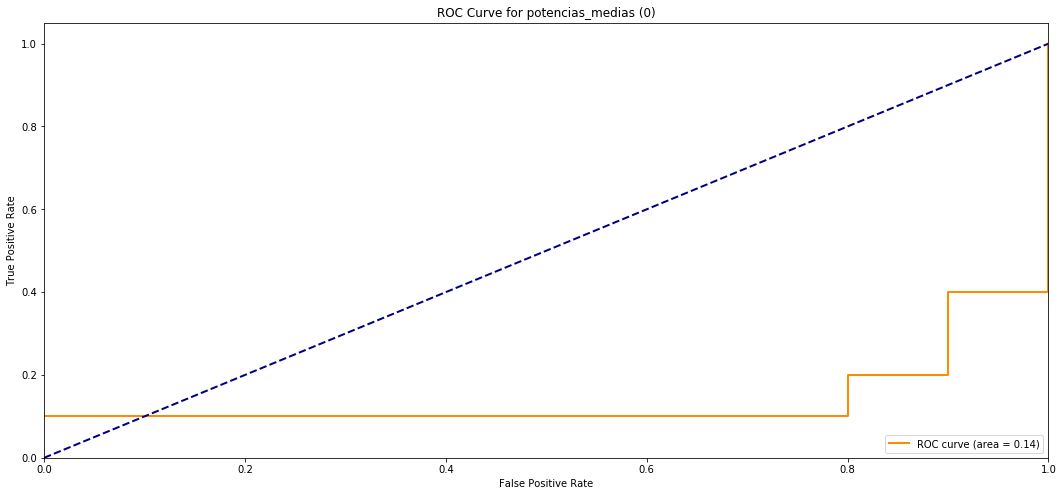

potencias_medias 1


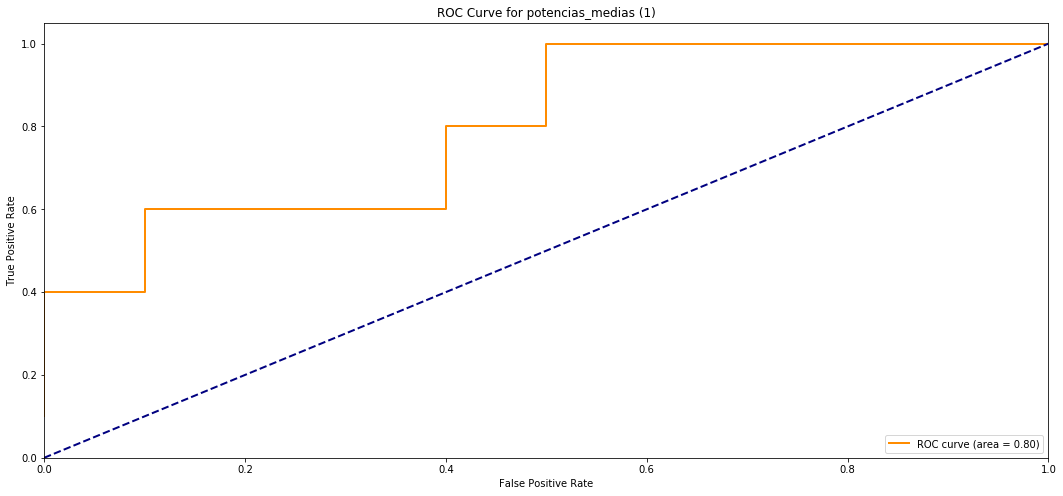

potencias_medias 2


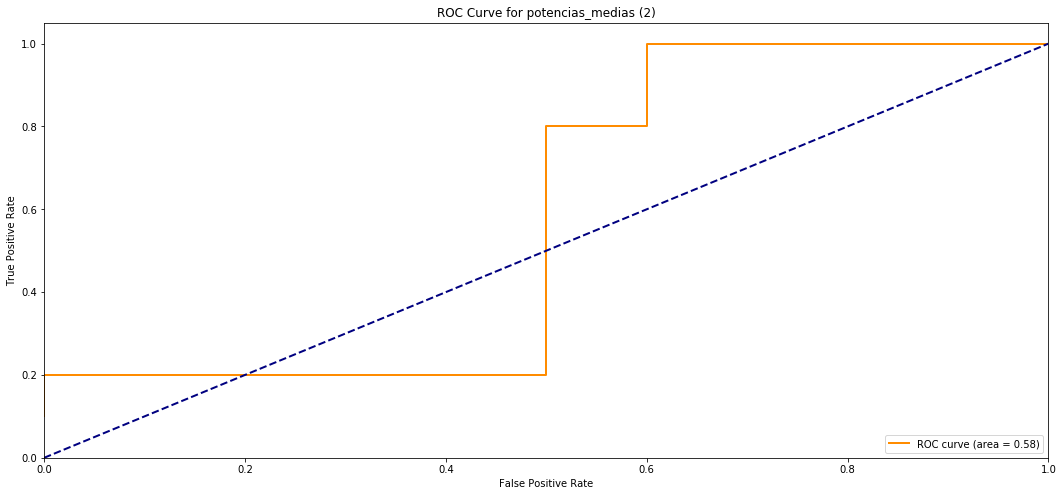

potencias_medias 3


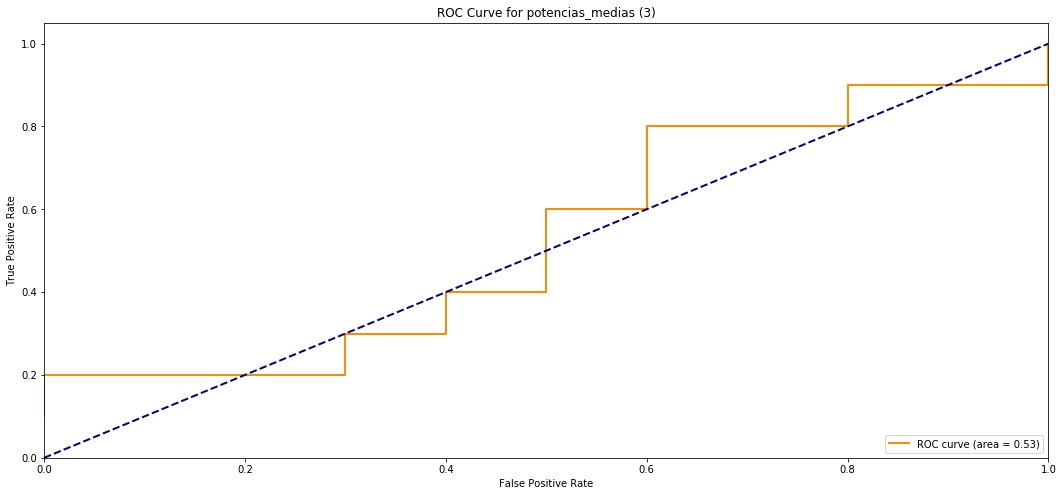

potencias_medias 4


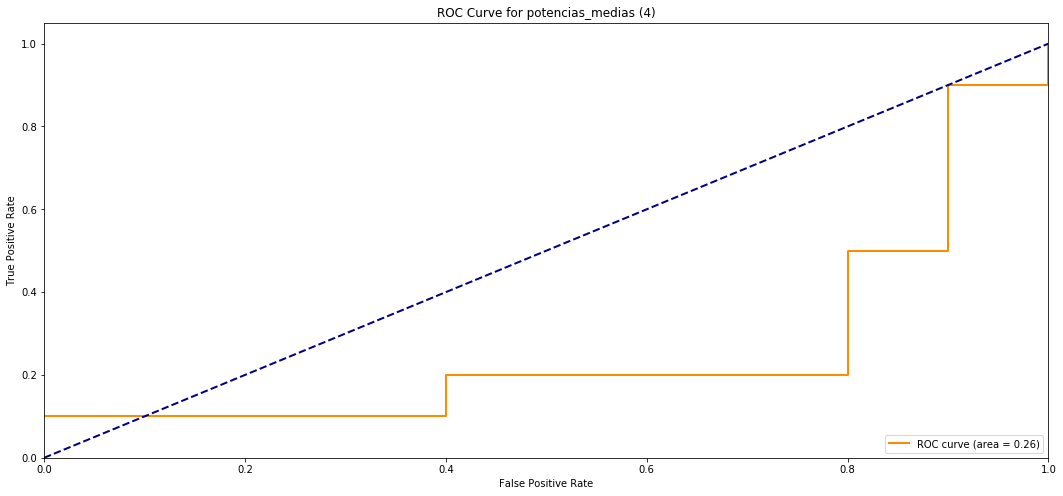

potencias_medias_norm 0


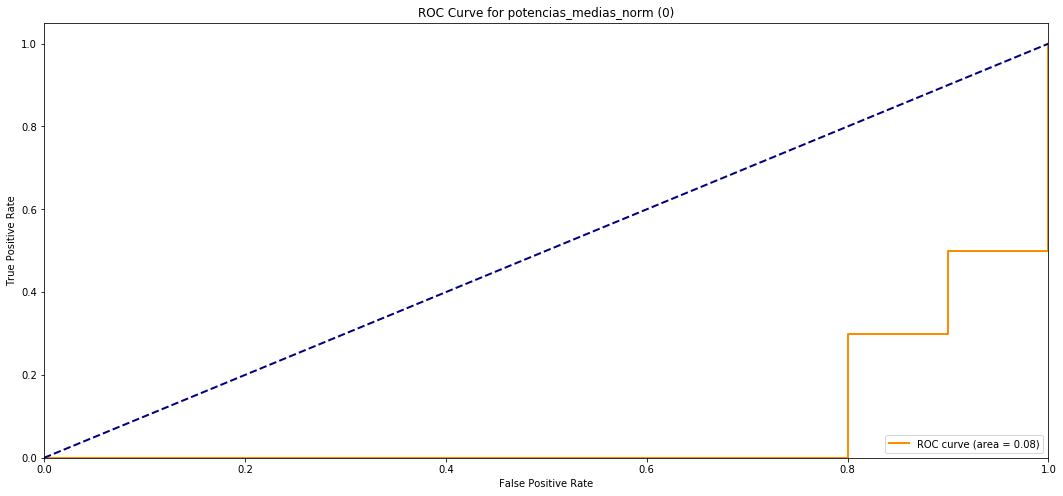

potencias_medias_norm 1


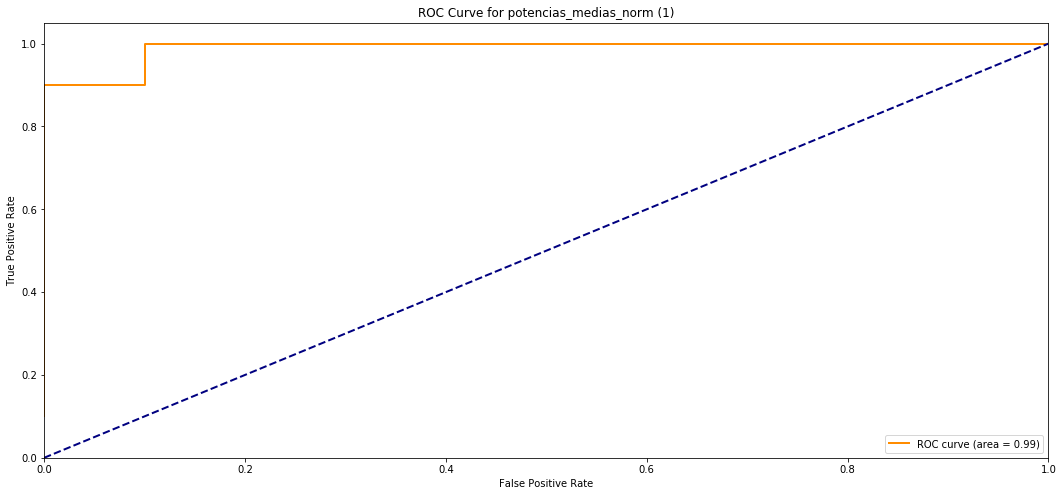

potencias_medias_norm 2


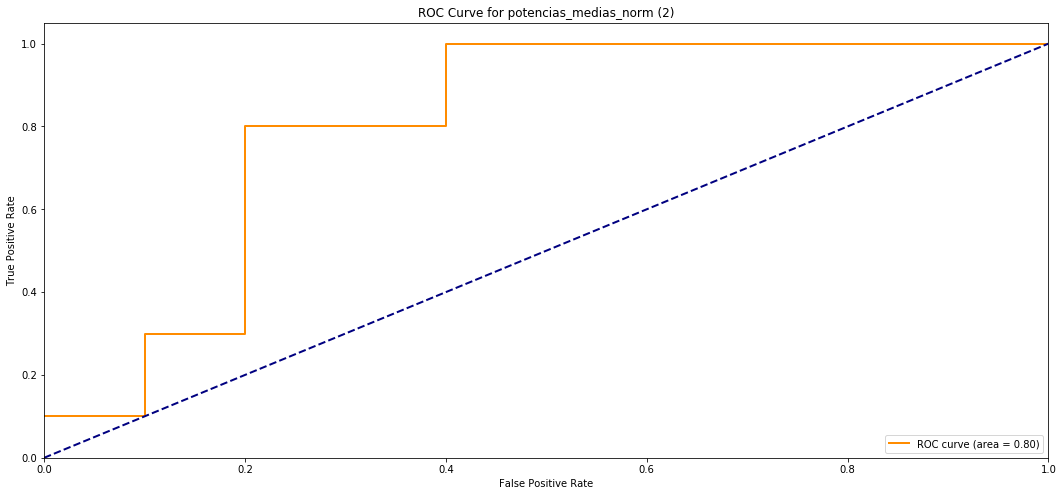

potencias_medias_norm 3


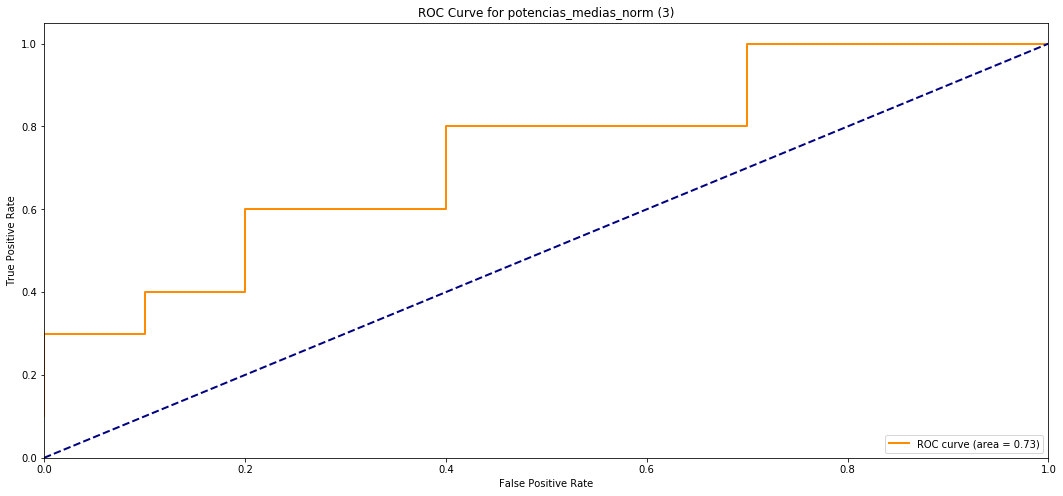

potencias_medias_norm 4


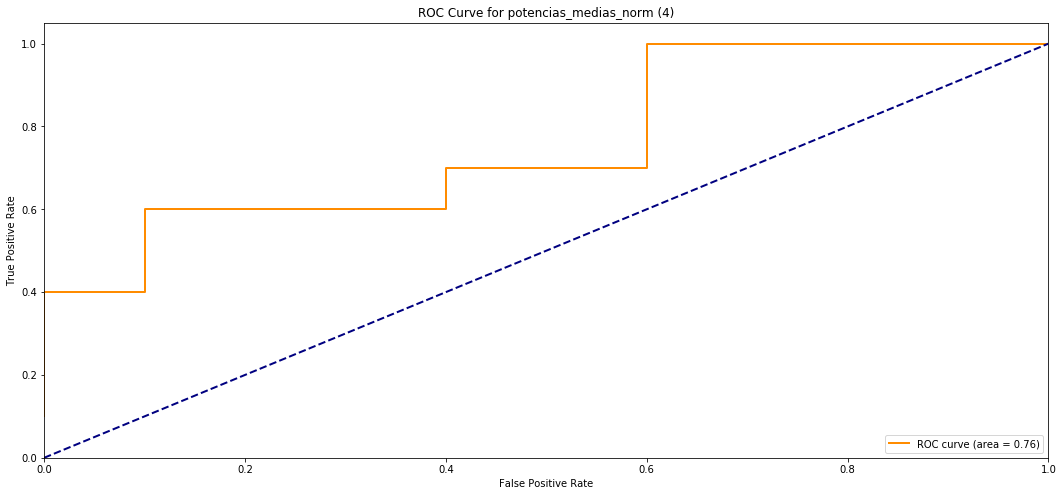

potencias_std 0


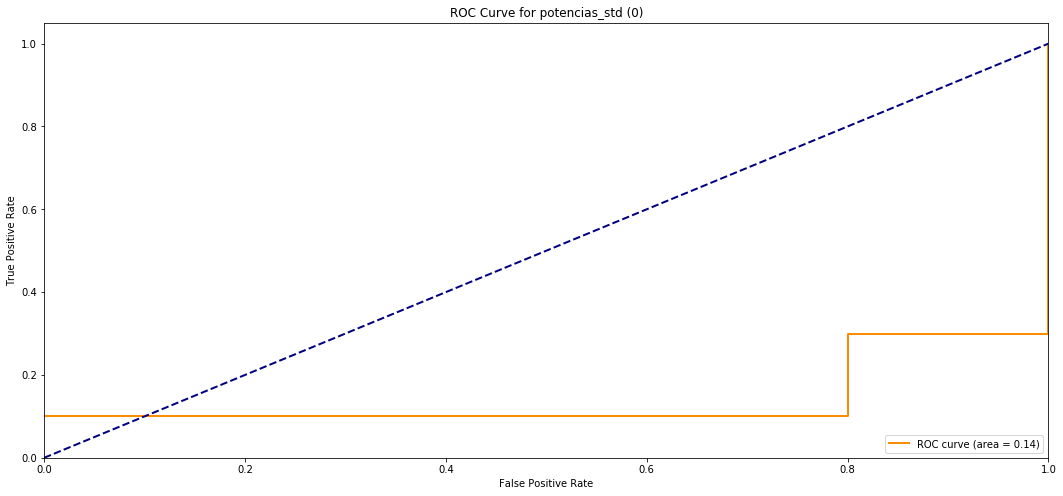

potencias_std 1


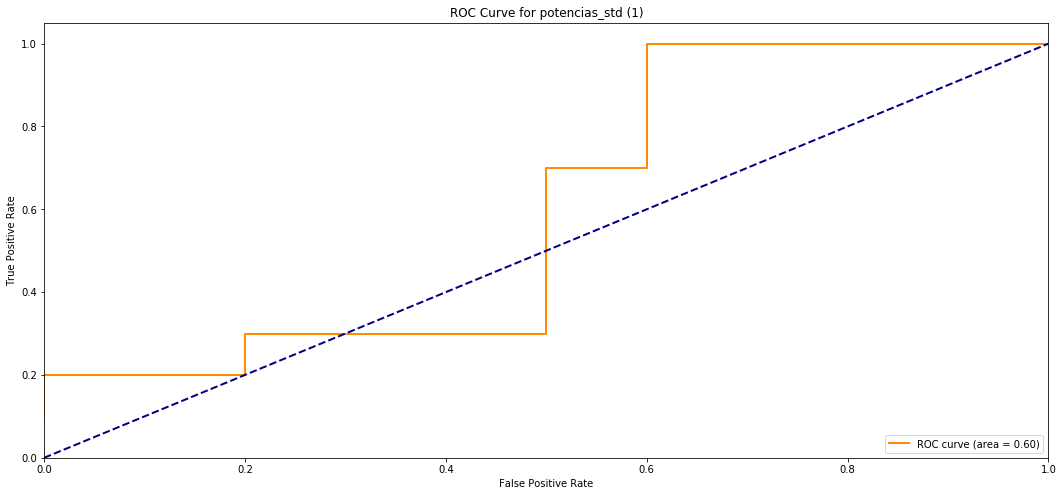

potencias_std 2


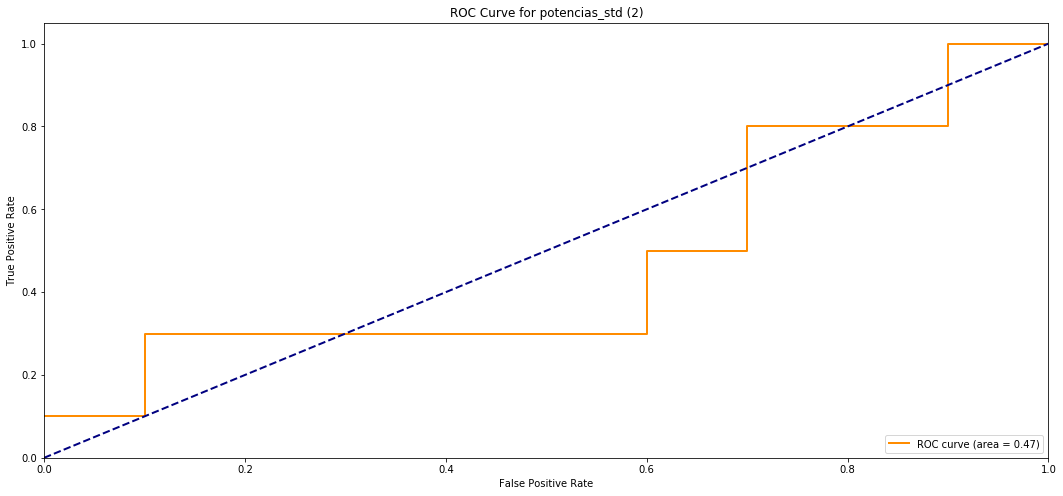

potencias_std 3


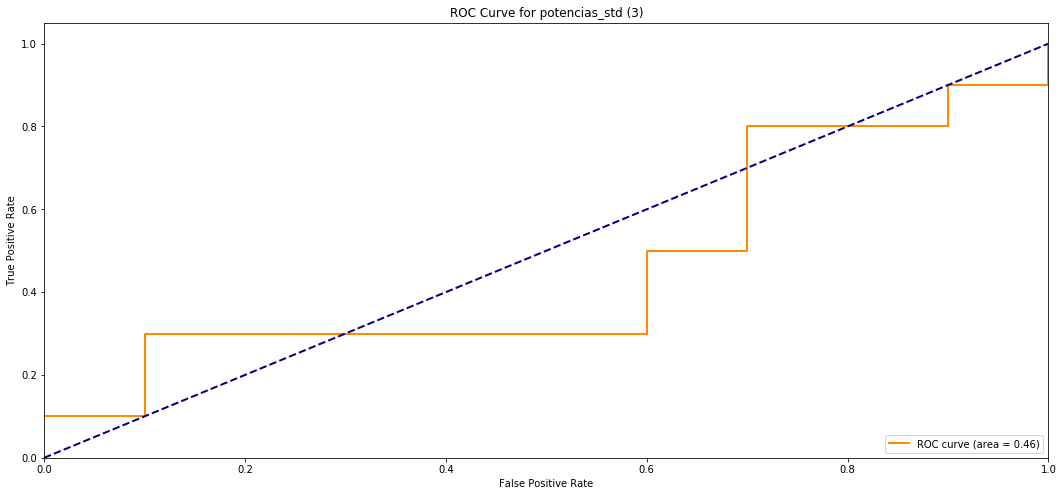

potencias_std 4


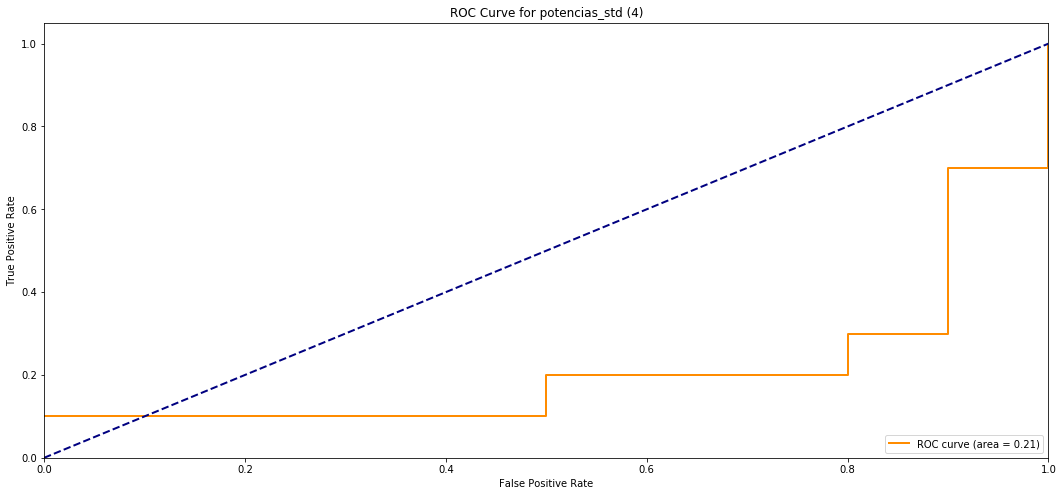

potencias_std_norm 0


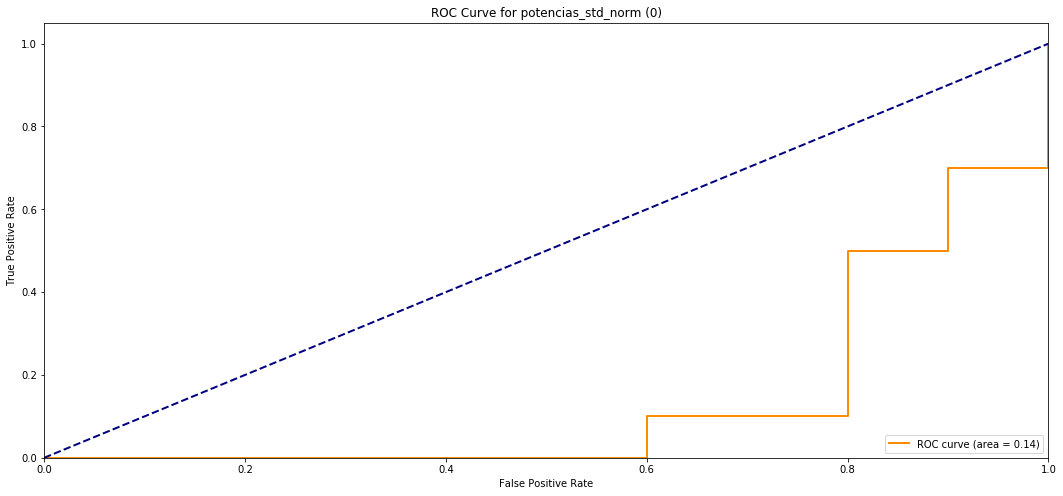

potencias_std_norm 1


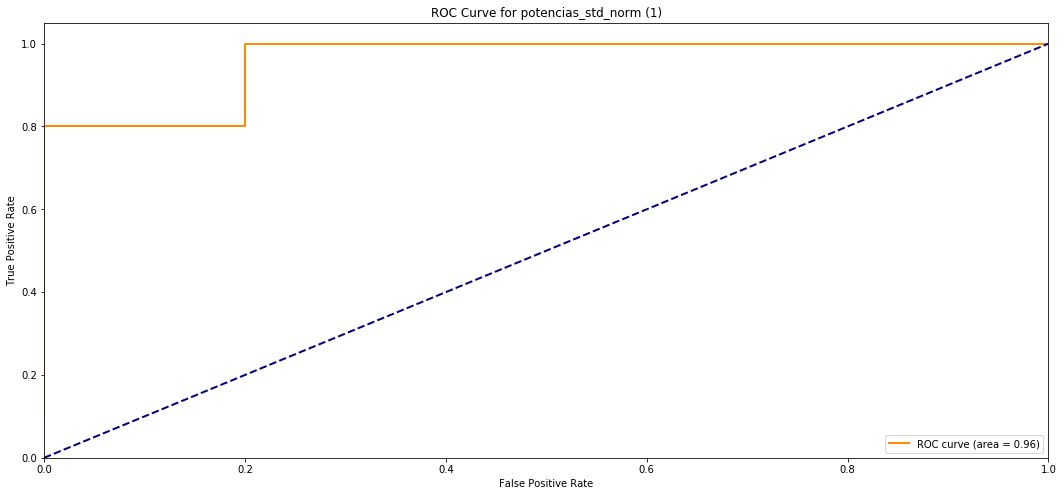

potencias_std_norm 2


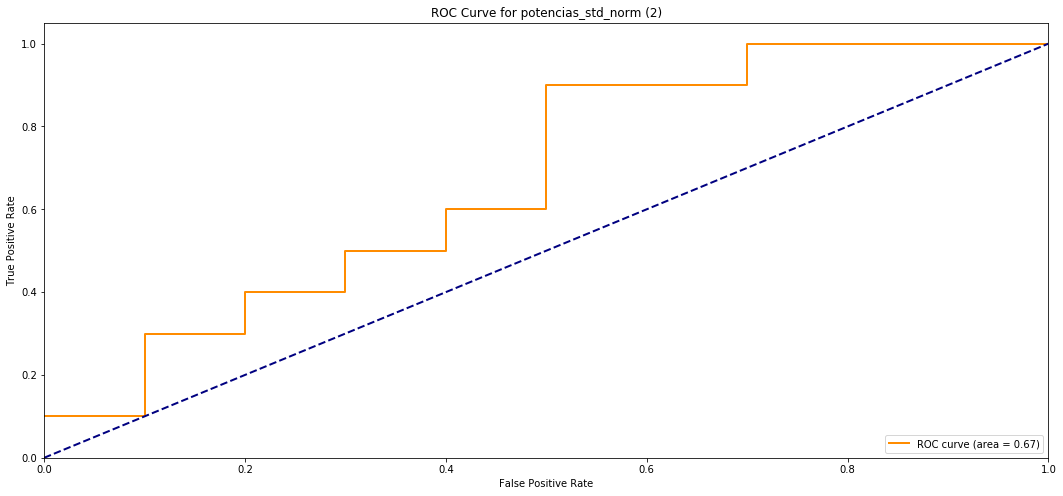

potencias_std_norm 3


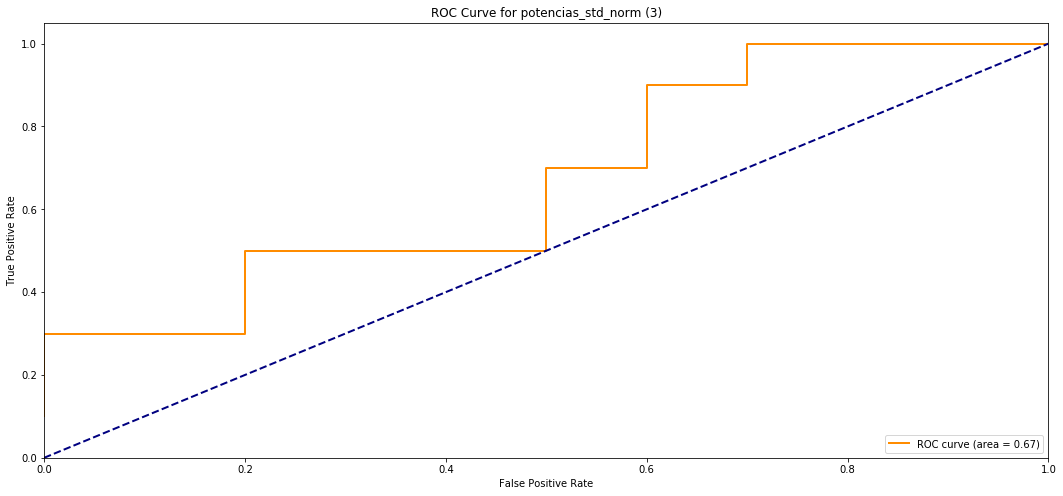

potencias_std_norm 4


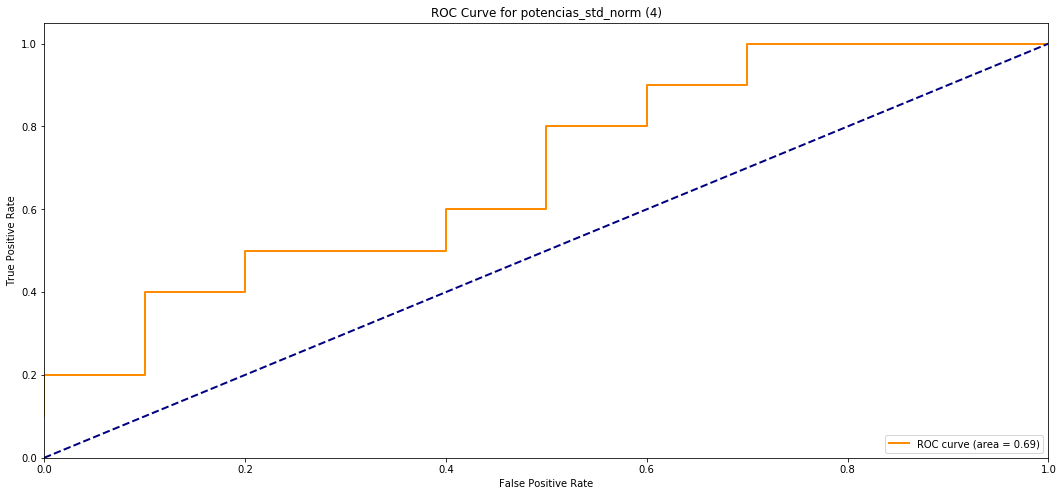

entropia_media None


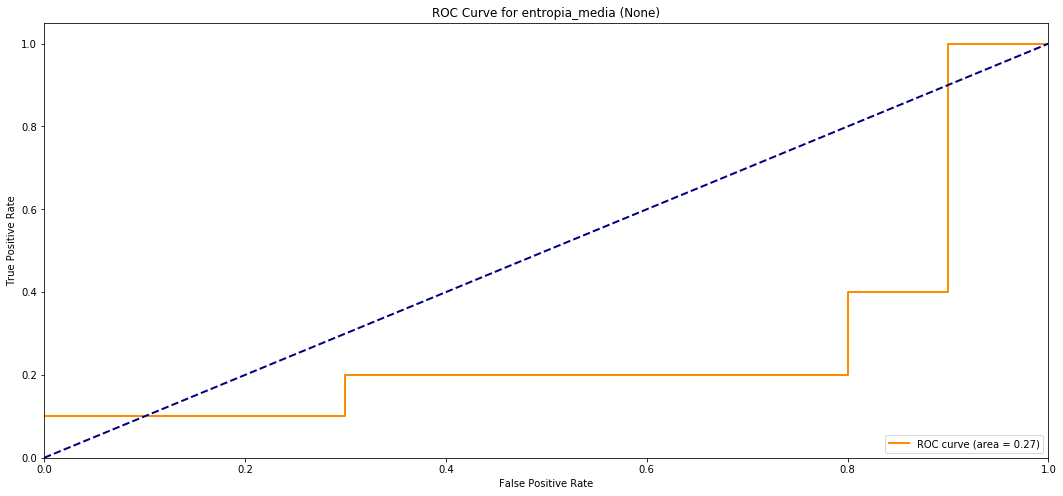

entropia_std None


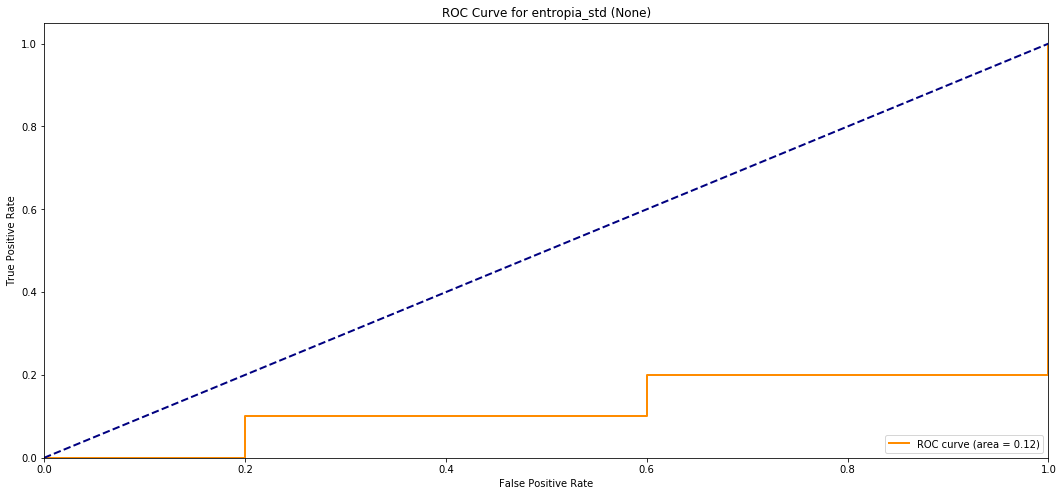

In [44]:
# P == 0, S == 1
def draw_roc_curve(attr, banda=None):
    y_true = [0 if 'P' in subject else 1 for subject in features_per_subject.keys()]
    y_score = [feature[attr] for feature in features_per_subject.values()]
    
    print(attr, banda)
    if banda is not None:
        y_score = [v[banda] for v in y_score]
        
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
        
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curve for {} ({})".format(attr, banda))
    plt.legend(loc="lower right")
    plt.show()
    
for feature_name, values in features_per_subject['P01'].items():
    if isinstance(values, float):
        draw_roc_curve(feature_name)
    else:
        for index, _ in enumerate(values):
            draw_roc_curve(feature_name, index)

In [46]:
for filename, features in features_per_subject.items():
    print(filename, features['potencias_medias_norm'][1])

P01 0.0299313130157
P02 0.0402059951583
P03 0.00984108143352
P04 0.0187229327216
P05 0.0534371018434
P06 0.0261572131856
P07 0.0329727554923
P08 0.0301071135595
P09 0.0655616146188
P10 0.0302311964308
S01 0.106108986234
S02 0.118573519986
S03 0.0828763051508
S04 0.132862619691
S05 0.0931538834875
S06 0.170433383292
S07 0.19949366786
S08 0.293377383986
S09 0.149156743607
S10 0.0542958407177
